# <center> LangGraph快速入门与Agent开发实战
# <center> Part 2.LangSmith工业级开发工具介绍

## 一、LangSmith 应用入门

&emsp;&emsp;大模型具有不确定性，尤其是构建复杂`AI Agent`应用程序中，中间会涉及非常多的子步骤，如果想要了解每一步的运行状态和结果，一方面可以通过`Debug`来进行实时控制，而另一方面可以借助一些工具来观察和调试中间的交互流程。`Langsmith`就是这样一个工具平台， 由​​ `LangChain` 和 `LangGraph` 背后的团队创建，**主要作用是：为基于大语言模型构建的应用程序提供全面的监控、调试和可观察性。提供强大的跟踪、日志记录和实时分析功能。**

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624185740544.png" alt="image-20250624185740544" style="zoom:33%;" />

> LangSmith官网：https://smith.langchain.com/

&emsp;&emsp;通常，对于一个项目而言，可以是单个应用程序或服务。该项目将包含多个跟踪，每个跟踪都是运行的集合 - 一个运行代表应用程序中的一个基本操作，例如对`DeepSeek`的`API`调用，或检索操作。如下图所示：

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241022164041124.png" width=80%></div>

- **Project (项目)：** 蓝色方块代表整个项目，可能是一个单独的应用程序或服务。
- **Traces (轨迹)：** 绿色方块代表项目在不同条件或配置下的执行路径。每个轨迹可以是一个特定的用户会话、一个功能的执行，或者应用在特定输入下的行为。
- **Runs (运行)：** 每个轨迹下的黄色方块表示特定轨迹的单次执行。这些是执行的实例，每个实例都是轨迹在特定条件下的实际运行。
- **Feedback, Tags, Metadata (反馈、标签、元数据)：** 这部分显示了系统如何利用用户或自动化工具生成的反馈、标签和元数据来增强轨迹的管理和过滤。反馈可以用于改进未来的运行，标签和元数据可用于分类和筛选特定的轨迹或运行，以便在LangSmith的用户界面中更容易地管理和审查

&emsp;&emsp;我们使用当前构建的 `LangGraph`图为例：

In [1]:
import os
from dotenv import load_dotenv 
load_dotenv(override=True)

DeepSeek_API_KEY = os.getenv("DEEPSEEK_API_KEY")

In [2]:
from langchain.chat_models import init_chat_model

model = init_chat_model(model="deepseek-chat", model_provider="deepseek")  

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver

# 1. 定义状态类（会自动合并 messages）
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 2. 初始化模型
model = init_chat_model(model="deepseek-chat", model_provider="deepseek")

# 3. 定义聊天节点
def chatbot(state: State) -> State:
    reply = model.invoke(state["messages"])
    return {"messages": [reply]}

# 4. 构建带 MemorySaver 的图
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

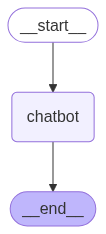

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

&emsp;&emsp;跟踪是请求通过图逻辑的步骤的详细记录。将其视为显示从开始到结束的确切顺序的路线图，在当前的设置中，`LangGraph` 很简单：
- 它以`__start__`节点开始
- 经过大模型生成回复的`chatbot`节点
- 结束于`__end__`节点。

&emsp;&emsp;每次用户与程序进行交互时，该图都会展开，并且此过程中的每个步骤都会记录为跟踪的一部分。借助 `Langsmith`，我们可以实时可视化和分析这些痕迹。设置 `Langsmith`并不复杂，我们需要依次执行如下操作步骤。

- **Step 1. 创建一个 LangSmith 帐户**

&emsp;&emsp;要开始使用 `LangSmith`，我们需要创建一个帐户。可以在这里注册一个免费帐户进入`LangSmith`登录页面： https://smith.langchain.com/ ， 支持使用 Google、GitHub、Discord 和电子邮件登录。

<center><div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506151835039.png" width=33%></div>

&emsp;&emsp;注册并等登录后，可以直接查看到仪表板：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624190009348.png" alt="image-20250624190009348" style="zoom:33%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624190049558.png" alt="image-20250624190049558" style="zoom:33%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624190123279.png" alt="image-20250624190123279" style="zoom:33%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624190228537.png" alt="image-20250624190228537" style="zoom:33%;" />

&emsp;&emsp;在构建程序跟踪前，首先需要创建一个 `API` 密钥，该密钥将允许我们的项目开始向 `Langsmith` 发送跟踪数据。

- **Step 2. 已创建账号的API密钥创建流程**

&emsp;&emsp;单击 `Langsmith` 仪表板左侧菜单中的“设置”图标。

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506151835041.png" width=80%></div>

&emsp;&emsp;导航至“API 密钥”部分，然后单击`Create API Key` 。

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506151835042.png" width=80%></div>

&emsp;&emsp;`LangSmith` 支持两种类型的 API 密钥：服务密钥和个人访问令牌。两种类型的令牌都可用于验证对 `LangSmith API` 的请求，但它们有不同的用例。这里选择“密钥类型令牌的个人访问” ，因为我们将使用此密钥作为用户进行个人访问。

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506151835043.png" width=80%></div>

&emsp;&emsp;单击“创建 API 密钥” ，复制并确认已保存。这和`DeepSeek`的`API`密钥一样，一旦创建完成，则不允许再次复制。

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506151835044.png" width=80%></div>

&emsp;&emsp;注意：退出后无法再复制，只能删除重建。

&emsp;&emsp;现在，就可以将其集成到我们的项目中了。

- **Step 3. 创建环境变量**

&emsp;&emsp;将`LANGCHAIN_API_KEY`替换为我们刚刚创建的 `API` 密钥。定义的方法如下：

In [5]:
import os

# 设置环境变量
os.environ["LANGSMITH_TRACING"]  = "true"                     # 开启追踪
os.environ["LANGSMITH_API_KEY"]  = "lsv2_pt_***" # 注意：这里替换为自己的LangSmith API Key
os.environ["LANGSMITH_PROJECT"]  = "langraph_chatbot"         # 任意项目名

# 验证环境变量是否设置成功
print(os.getenv("LANGSMITH_TRACING"))
print(os.getenv("LANGSMITH_API_KEY"))

true
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


&emsp;&emsp;在环境变量中设置以后，我们的代码不需要做任何的改变，即可构建`LangSmith`的消息跟踪。

In [6]:
import os
from dotenv import load_dotenv 
load_dotenv(override=True)

DeepSeek_API_KEY = os.getenv("DEEPSEEK_API_KEY")

In [7]:
from langchain.chat_models import init_chat_model

model = init_chat_model(model="deepseek-chat", model_provider="deepseek")  

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver

# 1. 定义状态类（会自动合并 messages）
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 2. 初始化模型
model = init_chat_model(model="deepseek-chat", model_provider="deepseek")

# 3. 定义聊天节点
def chatbot(state: State) -> State:
    reply = model.invoke(state["messages"])
    return {"messages": [reply]}

# 4. 构建带 MemorySaver 的图
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

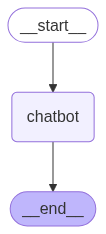

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

&emsp;&emsp;接下来正常进行多轮对话的问答，代码如下：

In [10]:
thread_config = {"configurable": {"thread_id": "session_1"}}

In [11]:
state1 = graph.invoke({"messages": [{"role":"user","content":"你好，好久不见，我叫陈明。"}]}, config=thread_config)

In [12]:
state1

{'messages': [HumanMessage(content='你好，好久不见，我叫陈明。', additional_kwargs={}, response_metadata={}, id='7df2fb6d-2bdb-4f12-8567-a0d328a0b1c3'),
  AIMessage(content='你好，陈明！确实好久不见啦～很高兴再次见到你！最近过得怎么样？有什么新鲜事想分享吗？或者有什么我可以帮你的呢？😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 12, 'total_tokens': 47, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '44f5c397-572e-47fa-a1dd-43cccc37d72e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--08d7a354-06a8-4f2e-95a7-3c3c28713617-0', usage_metadata={'input_tokens': 12, 'output_tokens': 35, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]}

In [13]:
state1['messages']

[HumanMessage(content='你好，好久不见，我叫陈明。', additional_kwargs={}, response_metadata={}, id='7df2fb6d-2bdb-4f12-8567-a0d328a0b1c3'),
 AIMessage(content='你好，陈明！确实好久不见啦～很高兴再次见到你！最近过得怎么样？有什么新鲜事想分享吗？或者有什么我可以帮你的呢？😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 12, 'total_tokens': 47, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '44f5c397-572e-47fa-a1dd-43cccc37d72e', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--08d7a354-06a8-4f2e-95a7-3c3c28713617-0', usage_metadata={'input_tokens': 12, 'output_tokens': 35, 'total_tokens': 47, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]

In [14]:
state1['messages'][-1].content

'你好，陈明！确实好久不见啦～很高兴再次见到你！最近过得怎么样？有什么新鲜事想分享吗？或者有什么我可以帮你的呢？😊'

&emsp;&emsp;当触发`Graph`执行时，可以在`LangSmith`控制面板上实时查看到该应用程序执行过程中各个状态的输入和输出情况。如下图所示：

<center>

<img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624190558402.png" alt="image-20250624190558402" style="zoom:33%;" />

&emsp;&emsp;点击进去可以查看到更加具体的追踪信息：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624190640491.png" alt="image-20250624190640491" style="zoom:33%;" />

&emsp;&emsp;至此，大家已经可以运行起`LangSmith`应用工具。在初次构建AI应用程序时，建议从最简单的工作流实现开始，结合 `LangSmith` 这样的评估工具是能够极大程度上帮助大家理解其中间过程。而随着构建应用程序的越来越复杂，其中间状态也会变得越来越多。

## 二、LangGraph Studio 可视化

&emsp;&emsp;`LangSmith` 与 `LangGraph Studio` 都是 `LangChain AI` 生态中非常核心的工具，前者是用于跟踪和分析大模型的使用情况，而`langGraph Studio`则是对于`LangGraph`来说，则是比`LangSmith`更加方便和高效的可视化调试工具平台。

&emsp;&emsp;大家可以思考一个问题：基于`LangGraph`框架可以开发出各种复杂的应用、`Agent`、`Workflow`等，那么这些应用、`Agent`、`Workflow`等在生产中如何部署和运行呢？ 解决方案就是把它们部署成一个`Server`。 而对如何方便高效的把`LangGraph`的`Graph`部署成一个`Server`，`LangGraph`官方提供了`LangGraph Platform`，其完整架构如下所示：

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506161127412.png" width=80%></div>

- **LangGraph Studio**：桌面版应用（`目前仅支持Mac`）和本地运行（适用于所有操作系统）；
- **LangServer**：最终构建出来的服务，提供`Assistant API`接口；
- **Python/JS SDK**：通过接口可以直接和 `LangServer` 提供的各个`API`接口连接；
- **Remote Graph**：类似于之前`LangServe`的用法，可以直接用 `Graph` 的接口去调用，这样拿到的`Graph`就是一个 `Runable`对象，就可以去调用它的`invoke`，`batch` 等。

&emsp;&emsp;`LangGraph Studio` 是专为 `LangGraph` 图式代理打造的本地/云端 `IDE`，具备可视化节点和状态及实时调试功能。`LangGraph Studio` 在本地可视化运行时会自动把调用过程上传到 `LangSmith`；而在 `LangSmith` 网页端查看任何 `Trace` 时，又能一键`Run in Studio`回放整条执行链，所以它是通过统一 `Trace SDK` 与 `LangSmith` 紧密集成。

&emsp;&emsp;接下来我们就来详细的讲解下如何使用`LangGraph Studio`。

&emsp;&emsp;首先需要说明的是，如果想要把一个定义的`Graph`添加到`LangGraph Studio`中，需要严格按照官方要求的项目结构进行构建，需要执行的步骤依次是：

- **Step 1. 创建一个`LangGraph`项目文件夹**

&emsp;&emsp;我们这里创建一个`langraph_chatbot`文件夹，如下图所示：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624190858497.png" alt="image-20250624190858497" style="zoom:50%;" />

- **Step 2. 创建`requirements.txt`文件**

&emsp;&emsp;在`langgraph_chatbot`文件夹中，新建一个`requirements.txt`文件，里面需要填写在运行该项目时需要安装的依赖项，如下所示：

```bash
langgraph
langchain-core
langchain-deepseek
python-dotenv
langsmith
```

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624191027491.png" alt="image-20250624191027491" style="zoom:33%;" />

- **Step 3. 创建`.env`文件**

&emsp;&emsp;在`langgraph_chatbot`文件夹中，新建一个`.env`文件，将敏感信息（如`API`密钥）放在环境变量中而不是硬编码。如下所示：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624191259742.png" alt="image-20250624191259742" style="zoom:33%;" />

- **Step 4. 创建`graph.py`文件**

&emsp;&emsp;在`langgraph_chatbot`文件夹中，新建一个`graph.py`文件，在该文件中编写构建图的具体运行逻辑，如状态、节点、变、图的编译等。注意：这里不要使用`init_chat_model`方法，而是使用`ChatDeepSeek`方法，因为会存在异步阻塞问题。代码如下所示：

```python
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_deepseek import ChatDeepSeek
from typing import Annotated
from typing_extensions import TypedDict
import os
from dotenv import load_dotenv 

# 加载环境变量
load_dotenv(override=True)

class State(TypedDict):
    """聊天机器人的状态定义"""
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    """聊天机器人节点函数"""
    model = ChatDeepSeek(model="deepseek-chat")
    return {"messages": [model.invoke(state["messages"])]}

# 构建图
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 编译图
graph = graph_builder.compile()
```

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624191412113.png" alt="image-20250624191412113" style="zoom:33%;" />

- **Step 5. 创建`langgraph.json`文件**

&emsp;&emsp;在`langgraph_chatbot`文件夹中，新建一个`langgraph.json`文件，在该`json`文件中配置项目信息，遵循规范如下所示：

- 必须包含 `dependencies` 和 `graphs` 字段
- `graphs` 字段格式："图名": "文件路径:变量名"
- 配置文件必须放在与Python文件同级或更高级的目录

&emsp;&emsp;注意: 项目文件的名称必须为`langgraph.json`。如下所示：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624191532218.png" alt="image-20250624191532218" style="zoom:33%;" />

&emsp;&emsp;其中：
- `dependencies`: ["./"] - 告诉`LangGraph`在当前目录查找依赖项（会自动读取`requirements.txt`）
- `chatbot`: "./graph.py:graph" - 定义图名为`chatbot`，来自`graph.py`文件中的`graph`变量
- `env`: ".env" - 指定环境变量文件位置

&emsp;&emsp;最终完整项目结构如下所示：

```json
    ./langraph_chatbot/
    ├── graph.py              # 对应官方的 agent.py
    ├── requirements.txt      # ✅ 依赖管理
    ├── langgraph.json       # ✅ 配置文件
    └── .env                 # ✅ 环境变量
```

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624191613003.png" alt="image-20250624191613003" style="zoom:50%;" />

&emsp;&emsp;完整的代码已经上传至百度网盘中的`langgraph_chatbot`文件夹中，大家可以扫描下方二维码免费领取

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624191855635.png" alt="image-20250624191855635" style="zoom:33%;" />

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/e873ea36c8a2263b2a88a0f86f9481b.png" alt="e873ea36c8a2263b2a88a0f86f9481b" style="zoom:50%;" />

&emsp;&emsp;然后，安装`langgraph-cli`依赖，执行如下代码：

```bash
    pip install -U "langgraph-cli[inmem]" -i https://pypi.tuna.tsinghua.edu.cn/simple
```

<center>

<img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624192025273.png" alt="image-20250624192025273" style="zoom:50%;" />

&emsp;&emsp;最后，进入到`langgraph_chatbot`文件夹，执行`LangGraph dev`即可启动项目

```bash
   langgraph dev
```

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624192113062.png" alt="image-20250624192113062" style="zoom:50%;" />

&emsp;&emsp;启动成功后，即可点击`Studio UI`中显示的链接，在浏览器中打开并访问`Studio`，如下所示：

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624195356912.png" alt="image-20250624195356912" style="zoom:33%;" />

完整演示流程如下所示：

In [16]:
Video("https://ml2022.oss-cn-hangzhou.aliyuncs.com/LangSmith%26Studio%20%E9%97%AE%E7%AD%94%E6%9C%BA%E5%99%A8%E4%BA%BA%E5%8F%AF%E8%A7%86%E5%8C%96%E8%B0%83%E8%AF%95.mp4", width=800, height=400)